In [62]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler

from sklearn.cluster import KMeans
from sklearn import metrics
from scipy.spatial.distance import cdist
import datetime as dt

In [15]:
data = pd.read_csv('Online_Retail.csv',encoding= 'unicode_escape')
df = data.copy()
df.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,12/1/10 8:26,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,12/1/10 8:26,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,12/1/10 8:26,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,12/1/10 8:26,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,12/1/10 8:26,3.39,17850.0,United Kingdom


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 541909 entries, 0 to 541908
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   InvoiceNo    541909 non-null  object 
 1   StockCode    541909 non-null  object 
 2   Description  540455 non-null  object 
 3   Quantity     541909 non-null  int64  
 4   InvoiceDate  541909 non-null  object 
 5   UnitPrice    541909 non-null  float64
 6   CustomerID   406829 non-null  float64
 7   Country      541909 non-null  object 
dtypes: float64(2), int64(1), object(5)
memory usage: 33.1+ MB


In [4]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
Quantity,541909.0,9.552250,218.081158,-80995.00,1.00,3.00,10.00,80995.0
UnitPrice,541909.0,4.611114,96.759853,-11062.06,1.25,2.08,4.13,38970.0
CustomerID,406829.0,15287.690570,1713.600303,12346.00,13953.00,15152.00,16791.00,18287.0


### Date operations

In [16]:
def dateOperations(df):
    df['InvoiceDate'] = df['InvoiceDate'].apply(lambda x: x.split(' ')[0])
    df['year'] = df['InvoiceDate'].apply(lambda x: "20" + str(int(x.split('/')[2])+10))
    df['day'] = df['InvoiceDate'].apply(lambda x: x.split('/')[0])
    df['month'] = df['InvoiceDate'].apply(lambda x: x.split('/')[1])
    df['InvoiceDate'] = df['day']+ '/' + df['month'] + '/'+df['year']
    df['InvoiceDate'] = pd.to_datetime(df['InvoiceDate'])
    df.drop(['day','month','year'], axis=1, inplace=True) 
    return df.head()
    
dateOperations(df)    
    


,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2020-12-01,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,2020-12-01,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2020-12-01,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2020-12-01,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2020-12-01,3.39,17850.0,United Kingdom


In [17]:
# remove negatives
df = df[(df['Quantity'] >0) & (df['UnitPrice'] >0)]

In [18]:
# Create total price columns
df['totalPrice'] = df['Quantity'] * df['UnitPrice']    

In [19]:
def bestSellingCountry(data):
    global n_df
    n_df = pd.DataFrame(data.groupby('Country')['totalPrice'].agg('sum').head()).reset_index()
    sumOfPrice = round(sum(data['totalPrice']),1)
    n_df['Percentage'] = n_df['totalPrice'].apply(lambda x: str(round((x/sumOfPrice) *100,2)) + "%")
    n_df.drop('totalPrice',axis=1,inplace=True)
    return n_df.sort_values(by='Percentage',ascending=False)
    

bestSellingCountry(df)

,Country,Percentage
0,Australia,1.3%
3,Belgium,0.39%
1,Austria,0.1%
2,Bahrain,0.01%
4,Brazil,0.01%


In [20]:
#remove NA values
df.dropna(inplace=True)

In [21]:
now =  dt.datetime(2022,1,1)

In [22]:
def createRFMTable(data):
    global rfm
    rfm = data.groupby('CustomerID').agg({
    'InvoiceDate': lambda x: (now-x.max()).days,
    'CustomerID': lambda x: len(x),
    'totalPrice' : lambda x: sum(x)
    })

    columns = ['Recency' , 'Frequency' , 'Monetary']
    rfm.columns = columns
    rfm.reset_index(inplace=True)
    
createRFMTable(df)


In [23]:
def createRFMscore(data):
    # find recency
    data.sort_values(by='Recency',ascending=True)
    data['R'] = pd.qcut(data['Recency'] , 5 ,labels=False)
    data['R'] = data['R'].apply(lambda x: int(x) + 1)
    
    # find frequency
    data.sort_values(by='Frequency',ascending=True)
    data['F'] = pd.qcut(data['Frequency'] , 5 ,labels=False)
    data['F'] = data['F'].apply(lambda x: int(x) + 1)
    
    # find monetary
    data.sort_values(by='Monetary',ascending=True)
    data['M'] = pd.qcut(data['Monetary'] , 5 ,labels=False)
    data['M'] = data['M'].apply(lambda x: int(x) + 1)
    
    # RFM segment
    data['RFM'] = data['F'].map(str) + data['R'].map(str) + data['M'].map(str) 
    

    return data
   

createRFMscore(rfm)

,CustomerID,Recency,Frequency,Monetary,R,F,M,RFM
0,12346.0,348,1,77183.60,5,1,5,155
1,12347.0,25,182,4310.00,1,5,5,515
2,12348.0,98,31,1797.24,4,3,4,344
3,12349.0,41,73,1757.55,2,4,4,424
4,12350.0,333,17,334.40,5,2,2,252
...,...,...,...,...,...,...,...,...
4333,18280.0,300,10,180.60,5,1,1,151
4334,18281.0,203,7,80.82,5,1,1,151
4335,18282.0,30,12,178.05,1,1,1,111
4336,18283.0,26,756,2094.88,1,5,5,515


In [27]:
rfm.CustomerID = rfm.CustomerID.astype('int64')

In [35]:
rfm.index = rfm.CustomerID
del rfm['CustomerID']

# Clustering and K-Means algorithm

In [44]:
rfm = rfm.iloc[:,0:3]

### Mix Max Scaling

In [53]:
scaled_data = pd.DataFrame(MinMaxScaler().fit_transform(rfm),columns = ['Recency','Frequency' , 'Monetary'])

In [54]:
scaled_data.head()

,Recency,Frequency,Monetary
0,0.871314,0.000000,0.275443
1,0.005362,0.023069,0.015368
2,0.201072,0.003824,0.006401
3,0.048257,0.009177,0.006259
4,0.831099,0.002039,0.001180


In [64]:

distortions = []
inertias = []
mapping1 = {}
mapping2 = {}
K = range(1, 5)
  
for k in K:
    kmeanModel = KMeans(n_clusters=k).fit(scaled_data)
  
    distortions.append(sum(np.min(cdist(scaled_data, kmeanModel.cluster_centers_,
                                        'euclidean'), axis=1)) / scaled_data.shape[0])
    inertias.append(kmeanModel.inertia_)
  
    mapping1[k] = sum(np.min(cdist(scaled_data, kmeanModel.cluster_centers_,
                                   'euclidean'), axis=1)) / scaled_data.shape[0]
    mapping2[k] = kmeanModel.inertia_

In [65]:

for key, val in mapping1.items():
    print(f'{key} : {val}')

1 : 0.21948766522973762
2 : 0.10117796707128993
3 : 0.07488615974165859
4 : 0.05579588593897517


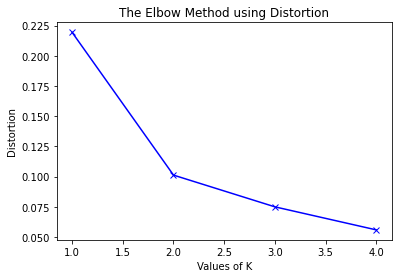

In [66]:

plt.plot(K, distortions, 'bx-')
plt.xlabel('Values of K')
plt.ylabel('Distortion')
plt.title('The Elbow Method using Distortion')
plt.show()

In [67]:
for key, val in mapping2.items():
    print(f'{key} : {val}')

1 : 319.9528541080951
2 : 72.06536371261144
3 : 38.81271987580737
4 : 25.257444997696044


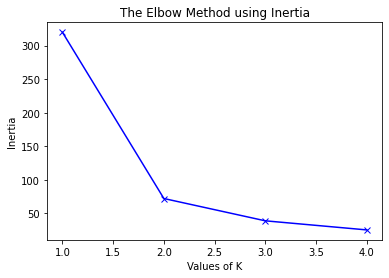

In [68]:
plt.plot(K, inertias, 'bx-')
plt.xlabel('Values of K')
plt.ylabel('Inertia')
plt.title('The Elbow Method using Inertia')
plt.show()

In [69]:
model = KMeans(n_clusters=3).fit(scaled_data)

In [73]:
pred_values = model.predict(scaled_data)

In [120]:
rfm['cluster'] = pred_values

In [115]:
cluster_counts = pd.DataFrame(scaled_data['cluster'].value_counts())
cluster_counts.columns = ['counts']
cluster_counts['cluster'] = ['0','1','2']
cluster_counts


,counts,cluster
0,2914,0
1,798,1
2,626,2


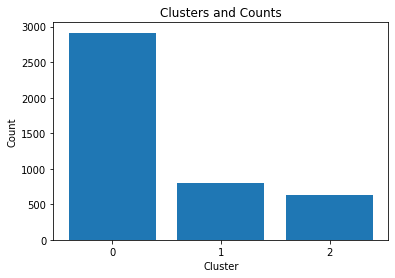

In [123]:
plt.bar(cluster_counts['cluster'],cluster_counts['counts'])
plt.title('Clusters and Counts')
plt.xlabel('Cluster')
plt.ylabel('Count')
plt.show()

In [121]:
rfm.groupby('cluster').mean()

,Recency,Frequency,Monetary
cluster,,,
0,54.855525,120.228895,2708.708117
1,176.531328,40.987469,799.659249
2,316.944089,23.688498,607.195479
